In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from astropy.io import fits
import warnings
import pandas
from spectral_cube import SpectralCube
import plotly.express as px
import astropy.units as u
from reproject import reproject_interp

warnings.filterwarnings('ignore')

In [2]:
nu11 = 23.6944955e9
nu33 = 23.8701292e9

west_path = '/home/scratch/hfwest/Pilot/'
morgan_path = '/home/scratch/lmorgan/Projects/GalacticBar/Midpoint_PaperII/Data/FitResults/'

gaussian_11 = SpectralCube.read(morgan_path + 'Pilot_NH3_11_Fit.fits')
gaussian_11 = gaussian_11.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nu11*u.Hz)
gaussian_33 = SpectralCube.read(morgan_path + 'Pilot_NH3_33_Fit.fits')
gaussian_33 = gaussian_33.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nu33*u.Hz)

gaussian_33_reprojected = []
for i in range(gaussian_33.shape[0]):
    slice_33 = gaussian_33[i].hdu
    reprojected_data, _ = reproject_interp(slice_33, gaussian_11[0].header)
    gaussian_33_reprojected.append(reprojected_data)

gaussian_33 = np.array(gaussian_33_reprojected)

# gaussian_11 = fits.open(morgan_path + 'Pilot_NH3_11_Fit.fits')[0].data
# gaussian_33 = fits.open(morgan_path + 'Pilot_NH3_33_Fit.fits')[0].data

# Shape: 285, 120, 220 [spectral depth, height, width] == [z, y, x]

In [3]:
nx = gaussian_11.shape[2]
ny = gaussian_11.shape[1]

mask_11 = np.full((ny, nx), np.nan)
mask_33 = np.full((ny, nx), np.nan)

for i in range(ny):
    for j in range(nx):
        if max(gaussian_11[:, i, j]) > 0:
            mask_11[i, j] = (gaussian_11.spectral_axis * u.s / u.km)[np.argmax(gaussian_11[:, i, j])]
        if max(gaussian_33[:, i, j]) > 0:
            # mask_33[i, j] = (gaussian_33.spectral_axis * u.s / u.km)[np.argmax(gaussian_33[:, i, j])]
            mask_33[i, j] = (gaussian_11.spectral_axis * u.s / u.km)[np.argmax(gaussian_33[:, i, j])]


x11, y11 = np.meshgrid(np.arange(mask_11.shape[1]), np.arange(mask_11.shape[0]))
x33, y33 = np.meshgrid(np.arange(mask_33.shape[1]), np.arange(mask_33.shape[0]))

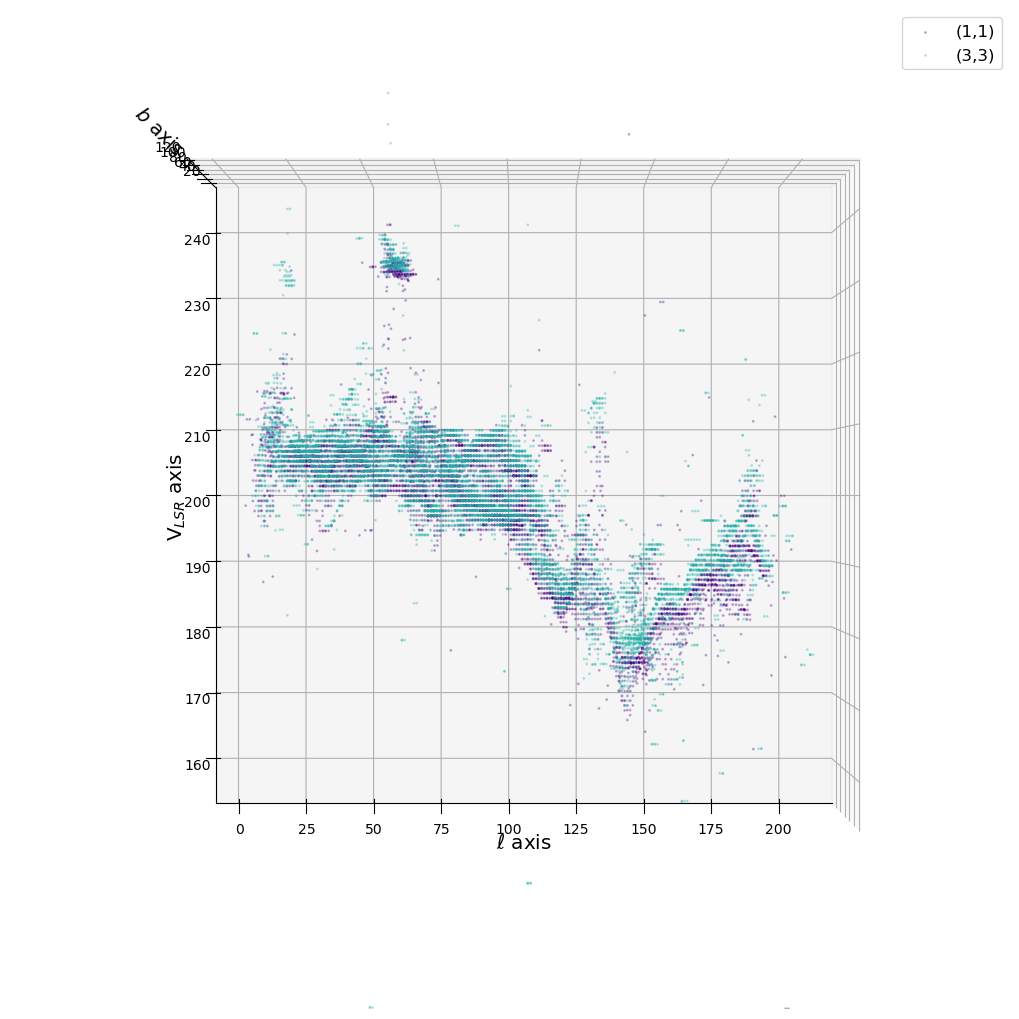

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
plt.tight_layout(pad = 0)

ax.scatter3D(x11, mask_11, y11, marker = '.', s = 5, label = '(1,1)', color = 'indigo', alpha = .25)
ax.scatter3D(x33, mask_33, y33, marker = '.', s = 5, label = '(3,3)', color = 'lightseagreen', alpha = .25)

ax.set_xlabel('$\ell$ axis', fontsize = 'x-large')
ax.set_zlabel('$b$ axis', fontsize = 'x-large')
ax.set_ylabel('V$_{LSR}$ axis', fontsize = 'x-large')
ax.legend(fontsize = 'large')

ax.set_ylim(155, 245)

# ### Actual gif perspective
# ax.view_init(elev = 90, azim = -90)
# def rotate(a):
#     ax.view_init(elev = 17, azim = a)
# anim = FuncAnimation(fig, rotate, frames = np.arange(-70, 290), interval = 30)
# anim.save('/home/scratch/hfwest/Pilot/Results/Reprojected_Vel_rotation_11_33.gif')

# ### Top down view
ax.view_init(elev= 90, azim = -90) # Top Down view
plt.show()

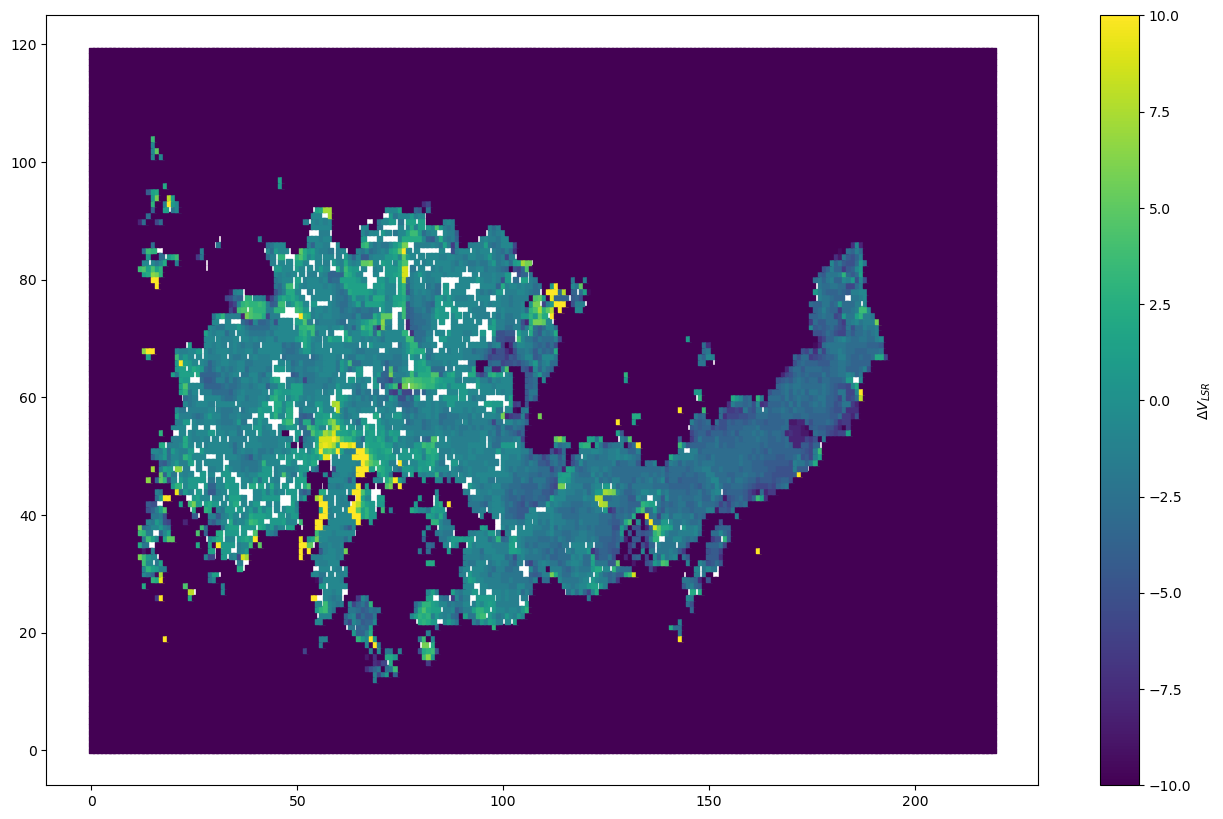

In [51]:
masked_delta = mask_11 - mask_33
for i in range(len(masked_delta)):
    for j in range(len(masked_delta[i])):
        if str(masked_delta[i, j]) == str(np.nan):
            masked_delta[i, j] = -999

plt.figure(figsize = (16, 10))
plt.scatter(x11[masked_delta != 0], y11[masked_delta != 0], c = masked_delta[masked_delta != 0], cmap = 'viridis', marker = ',', s = 15)
plt.colorbar(label = '$\Delta V_{LSR}$')
plt.clim(vmin = -10, vmax = 10)
plt.show()